<a href="https://colab.research.google.com/github/KeyMoney22/Plant_disease_classification-/blob/final/tomato_disease_detection_improved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TOMATO DISEASE DETECTION MODEL USING DEEP LEARNING**

# **1. INTRODUCTION**

## Overview

Tomatoes are one of the most important crops in Kenya, both economically and nutritionally. They are a staple in the diet of many Kenyans and a significant source of income for smallholder farmers. However, tomato production in Kenya faces numerous challenges, among which diseases are the most important. Tomato plants are susceptible to various diseases caused by fungi, bacteria, viruses, and pests. These diseases can lead to substantial yield losses, reduced produce quality, and increased production costs due to the need for pesticides and other control measures.

In Kenya, the impact of tomato diseases is exacerbated by several factors:

1. Limited Access to Knowledge and Resources: Many smallholder farmers lack access to information on disease identification and management practices.
2. Extension services are often inadequate, leaving farmers without the necessary support to effectively combat tomato diseases.

3. Climate and Environmental Conditions: Kenya's diverse climate and environmental conditions can create favorable conditions for the spread and persistence of various tomato diseases. Changes in weather patterns due to climate change further complicate disease management.

4. Economic Constraints: The financial constraints of smallholder farmers limit their ability to invest in disease management solutions such as resistant seed varieties, appropriate chemicals, and modern farming techniques.

5. Inadequate Diagnostic Tools: Traditional methods of disease diagnosis are often slow, inaccurate, and labor-intensive. There is a need for rapid, accurate, and cost-effective diagnostic tools that can be easily used by farmers in the field.


The consequences of unchecked tomato diseases are severe. Yield losses can range from 20% to 100%, depending on the type and severity of the disease. This not only affects the income of farmers but also threatens food security and nutrition for millions of Kenyans. Addressing tomato diseases effectively is therefore crucial for enhancing agricultural productivity, improving the livelihoods of smallholder farmers, and ensuring food security in Kenya.


## Business Problem

Agriculture is a cornerstone of Kenya's economy, with a majority of the population relying on it for their livelihood. However, plant diseases pose a significant threat to crop yields, leading to economic hardships for farmers and contributing to food insecurity. Traditional methods of disease detection are often slow, costly, and require expert knowledge. An automated plant disease detection system using image data can empower Kenyan farmers to quickly and accurately identify diseases, take timely actions, and improve crop productivity.

The goal of this project is to develop an automated system for detecting plant diseases in Kenya using image recognition technology. This system will enable farmers to identify various plant diseases from images of leaves, providing accurate and timely diagnostic information to help mitigate crop losses.

## Data Source

Our dataset was downloaded from a Kaggle repository authored by Plant Village.

PlantVillage is an organization hosted by Penn State University, is a research initiative focused on enhancing agricultural resilience and sustainability, particularly in the context of climate change. The platform employs advanced technologies such as artificial intelligence and data analytics to address various agricultural challenges including plant disease, which will be the focus of this project.
For this project we shall focus on Tomato Leaves.

The link to the repository is here: https://www.kaggle.com/datasets/emmarex/plantdisease?select=PlantVillage

Dataset Author Website: https://plantvillage.psu.edu/

## Objectives

1. Dataset Development: Collect and preprocess a diverse dataset of plant leaf images from Kenyan farms, labeled with various disease types.
2. Model Development: Build and train a Deep Learning model to classify images of plant leaves into healthy or diseased categories.
3. Model Evaluation: Evaluate the model’s performance using accuracy, precision, recall, and F1-score metrics.
4. Deployment: Develop a user-friendly mobile application that allows Kenyan farmers to upload images and receive disease diagnosis and treatment recommendations.
5. Impact Assessment: Evaluate the system’s impact on crop yield and farmer decision-making through pilot studies and feedback from Kenyan farmers.


## Metrics of Success

Model Accuracy: Achieve a classification accuracy of over 90%.


**IMPORTING THE LIBRARIES**

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from google.colab import drive
import os
from PIL import Image
from tensorflow.keras import models, layers
!pip install efficientnet
from tensorflow.keras.applications import VGG19, ResNet50, EfficientNetB0, MobileNetV2
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import json
!pip install wandb
import wandb
from wandb.integration.keras import WandbCallback


# **2.LOADING THE DATA**

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
folder_path='/content/drive/MyDrive/PlantVillage'

Found 16031 files belonging to 10 classes.
The length of our data is 501
Image Batch Shape (32, 256, 256, 3)
Label Batch Shape (32, 10)


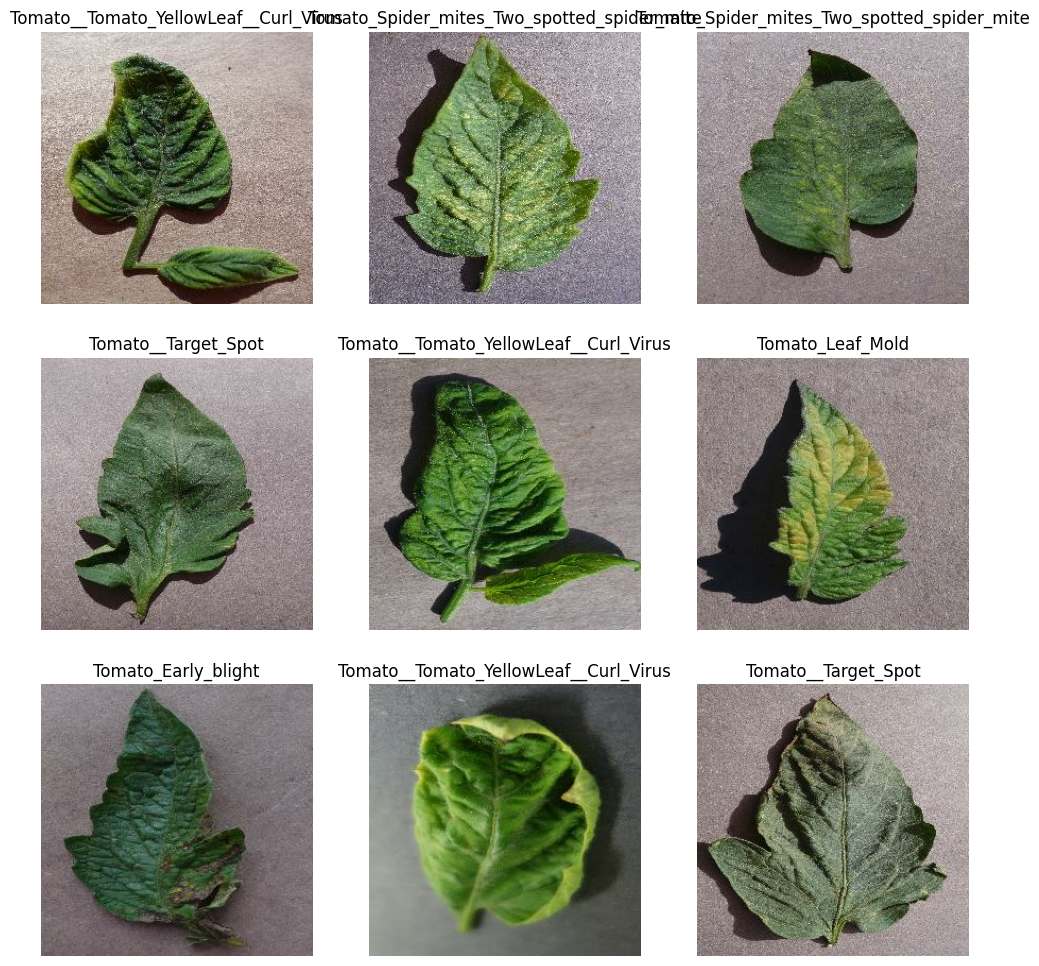

In [ ]:
data = tf.keras.utils.image_dataset_from_directory(
    folder_path,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True
)

print('The length of our data is', len(data))

for image_batch, label_batch in data:
    print('Image Batch Shape', image_batch.shape)
    print('Label Batch Shape', label_batch.shape)
    break

class_names = data.class_names

def preview_data(dataset, class_names, num_images=9):
    plt.figure(figsize=(12, 12))
    for images, labels in dataset.take(1):
        for i in range(num_images):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[tf.argmax(labels[i])])
            plt.axis("off")
    plt.show()

preview_data(data, class_names)


# **3.DATA CLEANING AND PREPARATION**

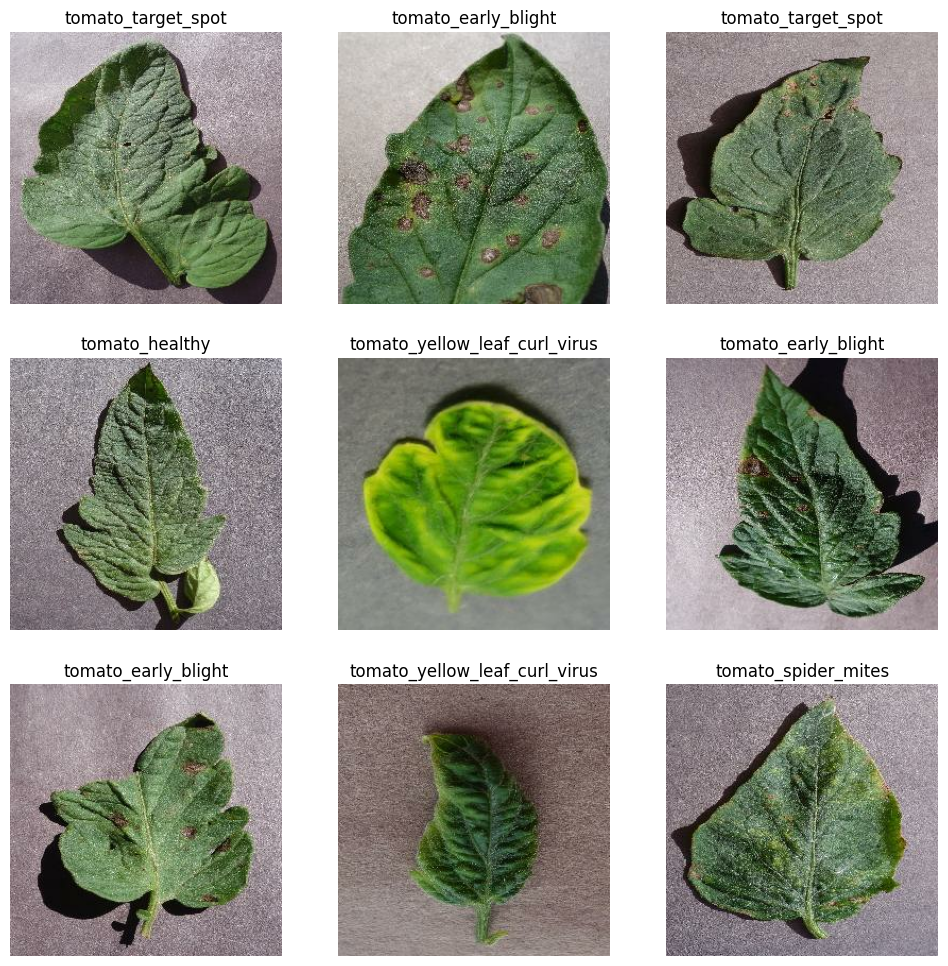

In [ ]:
def clean_class_name(name):
    name = name.replace('__', '_')
    if name == 'Tomato_Spider_mites_Two_spotted_spider_mite':
        name = 'Tomato_Spider_mites'
    elif name == 'Tomato_Tomato_YellowLeaf_Curl_Virus':
        name = 'Tomato_Yellow_Leaf_Curl_Virus'
    elif name == 'Tomato_Tomato_mosaic_virus':
        name = 'Tomato_Mosaic_Virus'
    name = name.lower()
    return name

class_names = [clean_class_name(name) for name in class_names]
preview_data(data, class_names)


**Checking For Corrupt Images**

In [ ]:
def check_corrupt_images(folder_path):
    corrupt_images = []
    for root, _, files in os.walk(folder_path):
        for file in files:
            try:
                img = Image.open(os.path.join(root, file))
                img.verify()  # Verify that it is, in fact, an image
            except (IOError, SyntaxError) as e:
                corrupt_images.append(os.path.join(root, file))
    return corrupt_images

corrupt_images = check_corrupt_images(folder_path)
print(f"Found {len(corrupt_images)} corrupt images.")

Found 0 corrupt images.


In [ ]:
# Removing Corrupt images
for img_path in corrupt_images:
    try:
      os.remove(img_path)
      print(f"Corrupt image removed:{img_path}")
    except OSError:
      pass

**Class Distribution**

In [ ]:
 # A function to check class distribution
def check_class_distribution(dataset):
    class_counts = {}
    for images, labels in dataset:
        for label in labels:
            class_name = class_names[tf.argmax(label)]
            if class_name in class_counts:
                class_counts[class_name] += 1
            else:
                class_counts[class_name] = 1
    return class_counts

# Checking class distribution
class_distribution = check_class_distribution(data)

# Sorting the dictionary by values (class counts) in ascending order
sorted_class_distribution = dict(sorted(class_distribution.items(), key=lambda item: item[1]))

print("Sorted class distribution (ascending):", sorted_class_distribution)


Sorted class distribution (ascending): {'tomato_mosaic_virus': 373, 'tomato_leaf_mold': 952, 'tomato_early_blight': 1000, 'tomato_target_spot': 1404, 'tomato_healthy': 1601, 'tomato_spider_mites': 1676, 'tomato_septoria_leaf_spot': 1771, 'tomato_late_blight': 1919, 'tomato_bacterial_spot': 2127, 'tomato_yellow_leaf_curl_virus': 3208}


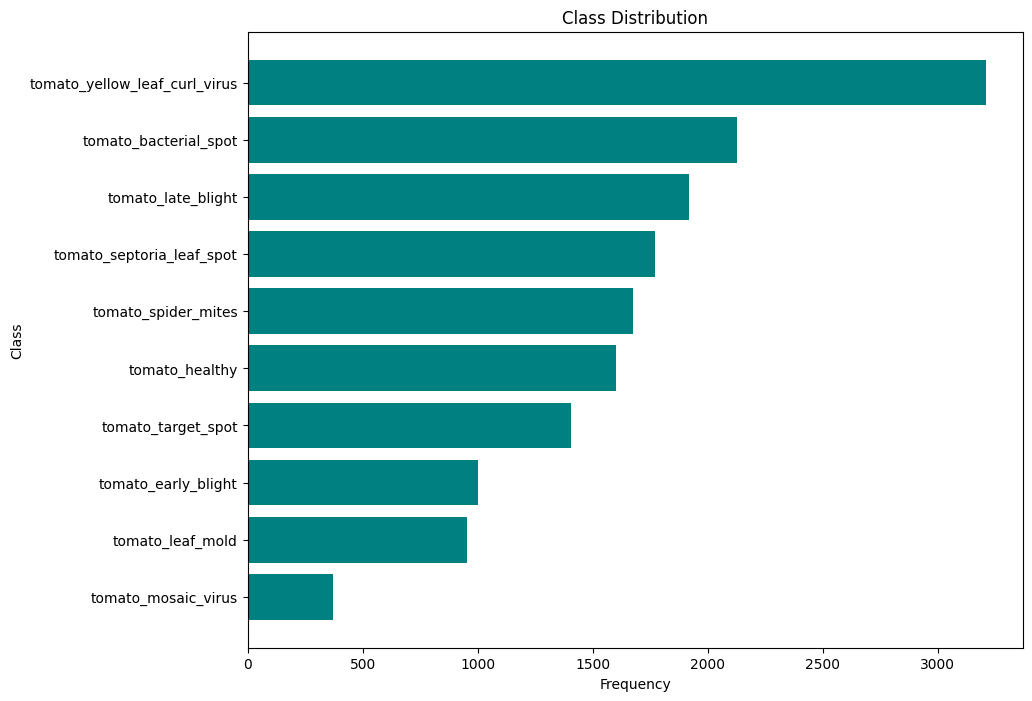

In [ ]:
# Visualize class distribution with a horizontal bar chart
plt.figure(figsize=(10, 8))
plt.barh(list(sorted_class_distribution.keys()), list(sorted_class_distribution.values()), color='Teal')
plt.title('Class Distribution')
plt.xlabel('Frequency')
plt.ylabel('Class')
plt.show();

# **4. SPLITTING THE DATASET**

In [ ]:
def split_data(dataset, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    data_size = len(dataset)
    if shuffle:
        dataset = dataset.shuffle(shuffle_size)

    train_size = int(train_split * data_size)
    val_size = int(val_split * data_size)

    train_set = dataset.take(train_size)
    val_set = dataset.skip(train_size).take(val_size)
    test_set = dataset.skip(train_size).skip(val_size)

    return train_set, val_set, test_set

train_set, val_set, test_set = split_data(data)
print(len(train_set))
print(len(val_set))
print(len(test_set))


400
50
51


# **5. DATA AUGMENTATION**

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2)
])

def augment(image, label):
    image = data_augmentation(image)
    return image, label

train_set = train_set.map(augment)


# **6. BUILDING THE MODELS**

In [ ]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(256, 256),
    layers.Rescaling(1.0/255)
])


In [ ]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True
)


**Model 1 : Simple CNN**

In [ ]:
model1 = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(32, 256, 256, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(class_names), activation='softmax'),
])

model1.build(input_shape=(32, 256, 256, 3))
model1.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (32, 127, 127, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [ ]:

model1.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history1 = model1.fit(
    train_set,
    batch_size=32,
    validation_data=val_set,
    verbose=1,
    epochs=50,
    callbacks=[early_stopping]
)


Epoch 1/50
400/400 [==============================] - 267s 597ms/step - loss: 1.6290 - accuracy: 0.4216 - val_loss: 1.8321 - val_accuracy: 0.4269
Epoch 2/50
400/400 [==============================] - 261s 588ms/step - loss: 0.8532 - accuracy: 0.6994 - val_loss: 0.9022 - val_accuracy: 0.6812
Epoch 3/50
400/400 [==============================] - 259s 583ms/step - loss: 0.6807 - accuracy: 0.7578 - val_loss: 0.9268 - val_accuracy: 0.6785
Epoch 4/50
400/400 [==============================] - 261s 587ms/step - loss: 0.5429 - accuracy: 0.8090 - val_loss: 0.7828 - val_accuracy: 0.7394
Epoch 5/50
400/400 [==============================] - 256s 579ms/step - loss: 0.4678 - accuracy: 0.8366 - val_loss: 0.6382 - val_accuracy: 0.7806
Epoch 6/50
400/400 [==============================] - 258s 585ms/step - loss: 0.3969 - accuracy: 0.8606 - val_loss: 0.6018 - val_accuracy: 0.8093
Epoch 7/50
400/400 [==============================] - 256s 574ms/step - loss: 0.3819 - accuracy: 0.8670 - val_loss: 0.6636 -

In [ ]:
# dumping the history to the json file
with open('history1.json','w') as f:
  json.dump(history1.history,f)

In [ ]:
model1.save('model1_initial.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


**Model 2 : VGG19**

In [ ]:
cnn_base = VGG19(weights='imagenet',
                 include_top=False,
                 input_shape=(256, 256, 3))
# Define Model Architecture
model2 = models.Sequential()
model2.add(cnn_base)
model2.add(layers.Flatten())
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dense(128, activation='relu'))
model2.add(layers.Dense(256, activation='relu'))
model2.add(layers.Dense(128, activation='relu'))
model2.add(layers.Dense(10, activation='softmax'))

cnn_base.trainable=False #freeze the base model to prevent the pretrained weights from being updated during training

for layer in model2.layers:
  print(layer.name, layer.trainable)

# check how many trainable weights are in the model
print(len(model2.trainable_weights))

model2.build(input_shape = (32, 256, 256, 3))
model2.summary()

80134624/80134624 [==============================] - 0s 0us/step
vgg19 False
flatten_1 True
dense_2 True
dense_3 True
dense_4 True
dense_5 True
dense_6 True
10
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 8, 8, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dense_2 (Dense)             (None, 64)                2097216   
                                                                 
 dense_3 (Dense)             (None, 128)               8320      
                                                                 
 dense_4 (Dense)             (None, 256)               33024     
                                                                 
 dense_5 (Dense)          

In [ ]:
model2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history2 = model2.fit(
    train_set,
    batch_size=32,
    validation_data=val_set,
    verbose=1,
    epochs=50,
    callbacks=[early_stopping]
)


Epoch 1/50
400/400 [==============================] - 431s 1s/step - loss: 1.1926 - accuracy: 0.6202 - val_loss: 0.6924 - val_accuracy: 0.7831
Epoch 2/50
400/400 [==============================] - 433s 1s/step - loss: 0.5865 - accuracy: 0.8044 - val_loss: 0.5774 - val_accuracy: 0.8106
Epoch 3/50
400/400 [==============================] - 434s 1s/step - loss: 0.4711 - accuracy: 0.8433 - val_loss: 0.5543 - val_accuracy: 0.8250
Epoch 4/50
400/400 [==============================] - 431s 1s/step - loss: 0.4098 - accuracy: 0.8651 - val_loss: 0.3203 - val_accuracy: 0.8875
Epoch 5/50
400/400 [==============================] - 430s 1s/step - loss: 0.3637 - accuracy: 0.8797 - val_loss: 0.4865 - val_accuracy: 0.8462
Epoch 6/50
400/400 [==============================] - 446s 1s/step - loss: 0.3575 - accuracy: 0.8820 - val_loss: 0.3111 - val_accuracy: 0.8969
Epoch 7/50
400/400 [==============================] - 445s 1s/step - loss: 0.3215 - accuracy: 0.8916 - val_loss: 0.2994 - val_accuracy: 0.8949

In [ ]:
# dumping the history to the json file
with open('history2.json','w') as f:
  json.dump(history2.history,f)

In [ ]:
model2.save('model2_initial.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


**Model 3:ResNet50**

In [ ]:
resnet50_base = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
resnet50_base.trainable = False

model3 = models.Sequential([
    resnet50_base,
    layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')  # Adjust output layer size
])

model3.build(input_shape=(32, 256, 256, 3))
model3.summary()


94765736/94765736 [==============================] - 1s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 24114826 (91.99 MB)
Trainable params: 527

In [ ]:
model3.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history3 = model3.fit(
    train_set,
    batch_size=32,
    validation_data=val_set,
    verbose=1,
    epochs=50,
    callbacks=[early_stopping]
)


Epoch 1/50
400/400 [==============================] - 457s 941ms/step - loss: 0.7369 - accuracy: 0.7490 - val_loss: 0.3881 - val_accuracy: 0.8725
Epoch 2/50
400/400 [==============================] - 408s 952ms/step - loss: 0.4320 - accuracy: 0.8505 - val_loss: 0.3364 - val_accuracy: 0.8925
Epoch 3/50
400/400 [==============================] - 408s 950ms/step - loss: 0.3548 - accuracy: 0.8778 - val_loss: 0.2856 - val_accuracy: 0.9075
Epoch 4/50
400/400 [==============================] - 405s 948ms/step - loss: 0.3278 - accuracy: 0.8876 - val_loss: 0.3523 - val_accuracy: 0.8849
Epoch 5/50
400/400 [==============================] - 400s 939ms/step - loss: 0.2990 - accuracy: 0.8998 - val_loss: 0.2228 - val_accuracy: 0.9281
Epoch 6/50
400/400 [==============================] - 401s 936ms/step - loss: 0.2703 - accuracy: 0.9038 - val_loss: 0.2805 - val_accuracy: 0.9081
Epoch 7/50
400/400 [==============================] - 401s 932ms/step - loss: 0.2578 - accuracy: 0.9107 - val_loss: 0.2080 -

In [ ]:
# dumping the history to the json file
with open('history3.json','w') as f:
  json.dump(history3.history,f)

In [ ]:
model3.save('model3_initial.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


**Model 4: EfficientNetB0**

In [ ]:
efficientnet_base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
efficientnet_base.trainable = False

model4 = models.Sequential([
    resize_and_rescale,
    efficientnet_base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(len(class_names),activation='softmax')
])

model4.build(input_shape=(32, 256, 256, 3))
model4.summary()


16705208/16705208 [==============================] - 0s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 efficientnetb0 (Functional  (None, 8, 8, 1280)        4049571   
 )                                                               
                                                                 
 global_average_pooling2d_1  (32, 1280)                0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (32, 128)                 163968    
                                                                 
 dense_3 (Dense)             (32, 64)                  8256      
                                                       

In [ ]:
model4.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history4 = model4.fit(
    train_set,
    batch_size=32,
    validation_data=val_set,
    verbose=1,
    epochs=50,
    callbacks=[early_stopping]
)


Epoch 1/50
400/400 [==============================] - 264s 574ms/step - loss: 2.2033 - accuracy: 0.2003 - val_loss: 2.1785 - val_accuracy: 0.2138
Epoch 2/50
400/400 [==============================] - 255s 571ms/step - loss: 2.2030 - accuracy: 0.1970 - val_loss: 2.1988 - val_accuracy: 0.2000
Epoch 3/50
400/400 [==============================] - 259s 580ms/step - loss: 2.2020 - accuracy: 0.1968 - val_loss: 2.1848 - val_accuracy: 0.2001
Epoch 4/50
400/400 [==============================] - 264s 593ms/step - loss: 2.2010 - accuracy: 0.1978 - val_loss: 2.2189 - val_accuracy: 0.1900


In [ ]:
# dumping the history to the json file
with open('history4.json','w') as f:
  json.dump(history4.history,f)

In [ ]:
model4.save('model4_initial.h5')

**Model 5: MobileNet V2**

In [ ]:
# Load MobileNet V2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the base model
base_model.trainable = False
# Create a new model
model5 = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')  # Adjust num_classes to your dataset
])

model5.build(input_shape=(32, 256, 256, 3))
model5.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 8, 8, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 128)               163968    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 10)                1290      
                                                                 
Total params: 2423242 (9.24 MB)
Trainable params: 1652

In [ ]:
# Compiling model
model5.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Use 'categorical_crossentropy' for one-hot encoded labels
              metrics=['accuracy'])

history5 = model5.fit(
    train_set,
    batch_size=32,
    validation_data=val_set,
    verbose=1,
    epochs=50,
    callbacks=[early_stopping]
)

Epoch 1/50
400/400 [==============================] - 193s 413ms/step - loss: 1.4966 - accuracy: 0.4727 - val_loss: 1.3202 - val_accuracy: 0.5288
Epoch 2/50
400/400 [==============================] - 204s 440ms/step - loss: 1.1823 - accuracy: 0.5780 - val_loss: 1.2864 - val_accuracy: 0.5387
Epoch 3/50
400/400 [==============================] - 198s 428ms/step - loss: 1.1057 - accuracy: 0.6080 - val_loss: 1.5109 - val_accuracy: 0.5063
Epoch 4/50
400/400 [==============================] - 191s 413ms/step - loss: 1.0436 - accuracy: 0.6334 - val_loss: 1.1428 - val_accuracy: 0.5987
Epoch 5/50
400/400 [==============================] - 198s 431ms/step - loss: 0.9984 - accuracy: 0.6468 - val_loss: 1.2848 - val_accuracy: 0.5741
Epoch 6/50
400/400 [==============================] - 197s 421ms/step - loss: 0.9732 - accuracy: 0.6562 - val_loss: 1.1296 - val_accuracy: 0.6237
Epoch 7/50
400/400 [==============================] - 198s 427ms/step - loss: 0.9399 - accuracy: 0.6661 - val_loss: 1.2086 -

In [ ]:
# dumping the history to the json file
with open('history5.json','w') as f:
  json.dump(history5.history,f)

In [ ]:
model5.save('model5_initial.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# **7.MODEL EVALUATION**

**Evaluate CNN(Model 1)**

In [ ]:
#Load saved CNN results
loaded_CNN = tf.keras.models.load_model('model1_initial.h5')

In [ ]:
test_loss1, test_acc1 = loaded_CNN.evaluate(test_set, verbose=2)
print('\nTest accuracy for CNN:', test_acc1)


51/51 - 30s - loss: 0.2679 - accuracy: 0.9142 - 30s/epoch - 595ms/step

Test accuracy for CNN: 0.9142156839370728


**Evaluate VGG19(Model 2)**

In [ ]:
# Load saved VGG19 results
loaded_VGG19 = tf.keras.models.load_model('model2_initial.h5')

In [ ]:
test_loss2, test_acc2 = loaded_VGG19.evaluate(test_set, verbose=2)
print('\nTest accuracy for VGG19:', test_acc2)


51/51 - 66s - loss: 0.3397 - accuracy: 0.8854 - 66s/epoch - 1s/step

Test accuracy for VGG19: 0.8854166865348816


**Evaluate ResNet50(Model 3)**

In [ ]:
# Load saved Resnet50 results
loaded_Resnet50 = tf.keras.models.load_model('model3_initial.h5')

In [ ]:
test_loss3, test_acc3 = loaded_Resnet50.evaluate(test_set, verbose=2)
print('\nTest accuracy for ResNet50:', test_acc3)


51/51 - 70s - loss: 0.1666 - accuracy: 0.9418 - 70s/epoch - 1s/step

Test accuracy for ResNet50: 0.9417892098426819


**Evaluate EfficientNetB0(Model 4)**

In [ ]:
# Load saved EfficientNet results
loaded_Efficientnet = tf.keras.models.load_model('model4_initial.h5')

In [ ]:
test_loss4, test_acc4 = loaded_Efficientnet.evaluate(test_set, verbose=2)
print('\nTest accuracy for EfficientNetB0:', test_acc4)


51/51 - 49s - loss: 2.2017 - accuracy: 0.2017 - 49s/epoch - 955ms/step

Test accuracy for EfficientNetB0: 0.20171673595905304


**Evaluate MobileNetV2(Model 5)**

In [ ]:
# Load saved MobileNetV2 results
loaded_MobileNetV2 = tf.keras.models.load_model('model5_initial.h5')

In [ ]:
test_loss5, test_acc5 = loaded_MobileNetV2.evaluate(test_set, verbose=2)
print('\nTest accuracy for MobileNetV2:', test_acc5)


51/51 - 40s - loss: 1.0800 - accuracy: 0.6415 - 40s/epoch - 792ms/step

Test accuracy for MobileNetV2: 0.6415441036224365


# **8.PLOTTING THE TRAINING HISTORY**

In [ ]:
def plot_training_history(history):
  # Check if the history is a dictionary (loaded from JSON)
  if isinstance(history, dict):
    # Extract metrics from the dictionary
    accuracy = history.get('accuracy', [])
    val_accuracy = history.get('val_accuracy', [])
    loss = history.get('loss', [])
    val_loss = history.get('val_loss', [])
  else:
    # Use the history object directly
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

  # Plot training & validation accuracy values
  plt.plot(accuracy)
  plt.plot(val_accuracy)
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left') # Fix: Removed the non-breaking space in 'upper left'
  plt.show()

  # Plot training & validation loss values
  plt.plot(loss)
  plt.plot(val_loss)
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left') # Fix: Removed the non-breaking space in 'upper left'
  plt.show()

**CNN MODEL ACCURACY**

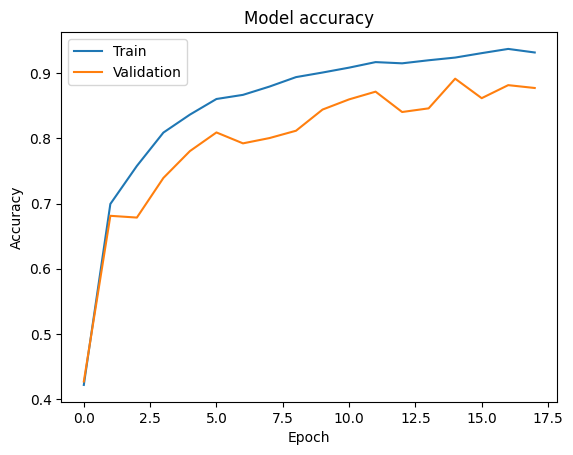

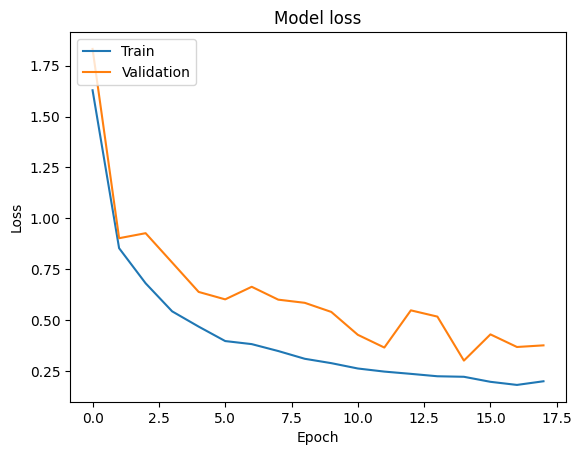

In [ ]:
cnn_plot = plot_training_history(history1)
cnn_plot


**VGG19 MODEL ACCURACY**

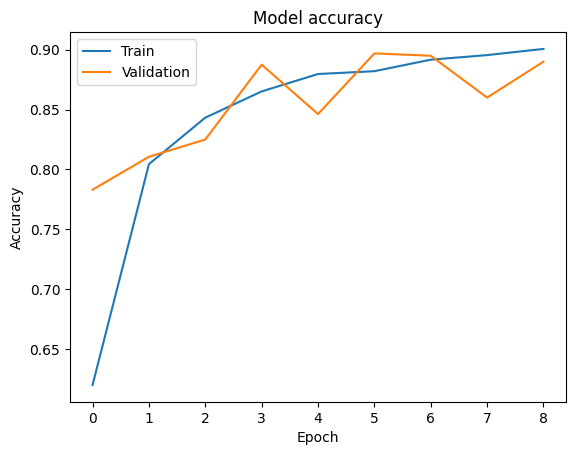

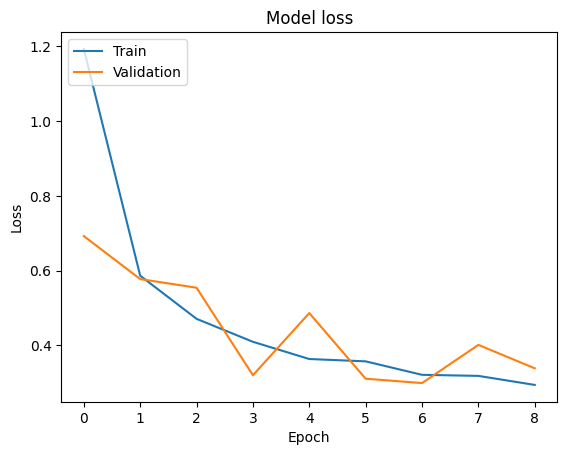

In [ ]:
vgg19_plot = plot_training_history(history2)
vgg19_plot

**RESNET50 MODEL ACCURACY**

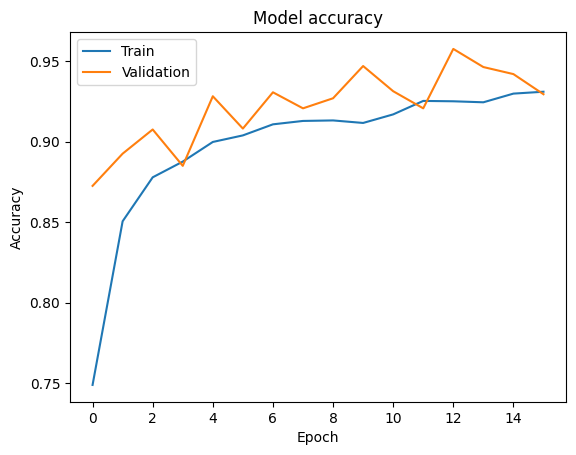

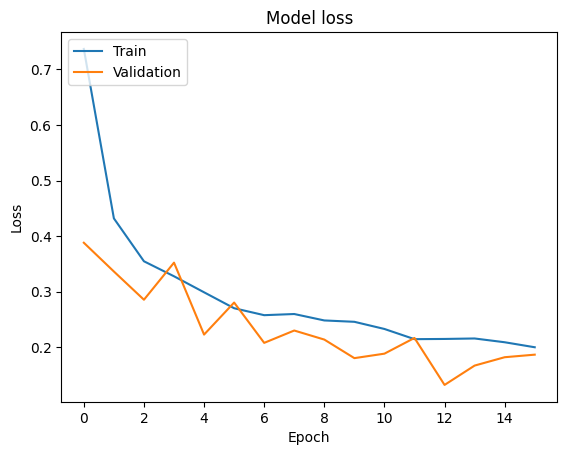

In [ ]:
resnet50_plot = plot_training_history(history3)
resnet50_plot

**EFFICIENTNETB0 MODEL ACCURACY**

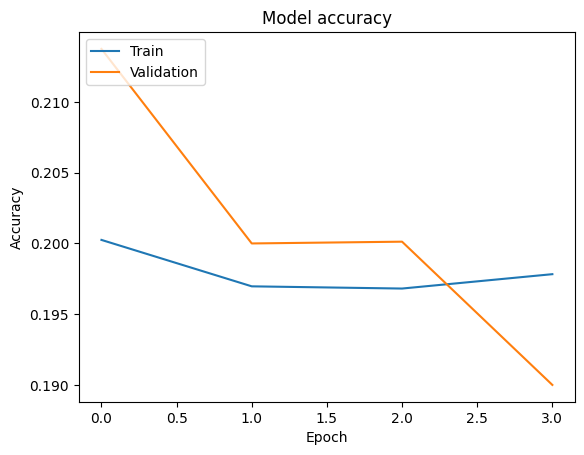

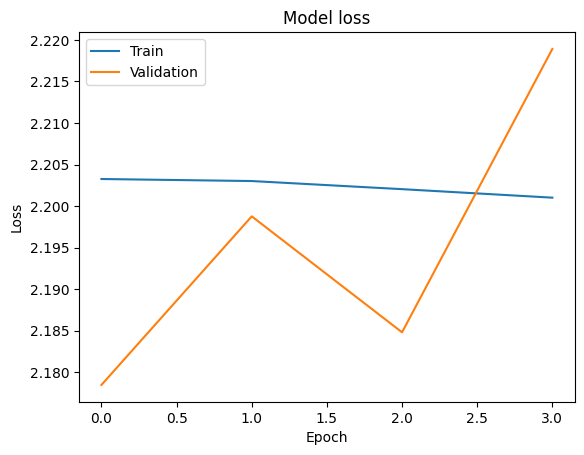

In [ ]:
efficientnet_plot = plot_training_history(history4)
efficientnet_plot

**MOBILENET V2 MODEL ACCURACY**

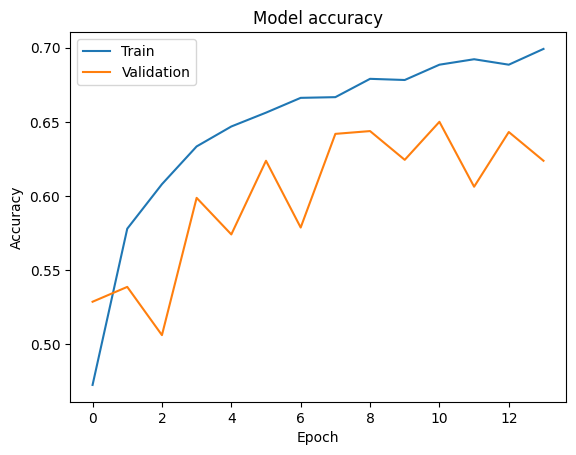

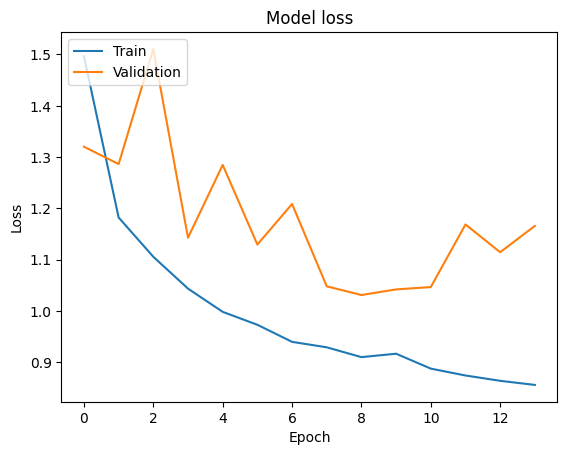

In [ ]:
mobilenet_plot = plot_training_history(history5)
mobilenet_plot

# **9. HYPERPARAMETER TUNING**

**Model 1: CNN Tuning**

**Model 2 : VGG19 Tuning**

**Model 3 :ResNet50 Tuning**

In [ ]:
#importing optimizers
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
# Initialize Weights & Biases
wandb.init(project="resnet-hyperparameter-tuning")
# Define hyperparameters
hyperparameters = {
    'epochs': 50,
    'batch_size': 32,
    'learning_rate': 1e-4,
    'dropout_rate': 0.5,
    'dense_units': 128
}

# Save hyperparameters
wandb.config.update(hyperparameters)
# # Freeze the base model
# base_model.trainable = False

# # Create a new model
model_restune = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(wandb.config.dense_units, activation='relu'),
    layers.Dropout(wandb.config.dropout_rate),
    layers.Dense(len(class_names), activation='softmax')  # Adjust num_classes to your dataset
])

# model.build(input_shape=(None, 256, 256, 3))
# model.summary()
# # Compile the model
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=wandb.config.learning_rate),
#               loss='categorical_crossentropy',  # Use 'categorical_crossentropy' for one-hot encoded labels
#               metrics=['accuracy'])
# # Callbacks
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# # Train the model
# history = model.fit(
#     train_set,
#     validation_data=val_set,
#     epochs=wandb.config.epochs,
#     callbacks=[early_stopping, reduce_lr, WandbCallback()]
# )

# Unfreeze some layers of the base model for fine-tuning
base_model.trainable = True
fine_tune_at = len(base_model.layers) // 2  # Unfreeze the top half layers

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Compile the model again after unfreezing
model_restune.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tune the model
history_fine = model_restune.fit(
    train_set,
    validation_data=val_set,
    epochs=wandb.config.epochs,
    callbacks=[early_stopping, reduce_lr, WandbCallback()]
)

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/50
400/400 [==============================] - ETA: 0s - loss: 1.9702 - accuracy: 0.3210

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240731_165007-k9l9rn00/files/model-best)... Done. 0.1s


400/400 [==============================] - 260s 559ms/step - loss: 1.9702 - accuracy: 0.3210 - val_loss: 2.1965 - val_accuracy: 0.2706 - lr: 1.0000e-05
Epoch 2/50
400/400 [==============================] - ETA: 0s - loss: 1.3604 - accuracy: 0.5447

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240731_165007-k9l9rn00/files/model-best)... Done. 0.1s


400/400 [==============================] - 235s 525ms/step - loss: 1.3604 - accuracy: 0.5447 - val_loss: 1.7628 - val_accuracy: 0.4038 - lr: 1.0000e-05
Epoch 3/50
400/400 [==============================] - ETA: 0s - loss: 1.1287 - accuracy: 0.6225

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240731_165007-k9l9rn00/files/model-best)... Done. 0.1s


400/400 [==============================] - 249s 556ms/step - loss: 1.1287 - accuracy: 0.6225 - val_loss: 1.5750 - val_accuracy: 0.4594 - lr: 1.0000e-05
Epoch 4/50
400/400 [==============================] - ETA: 0s - loss: 0.9773 - accuracy: 0.6693

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240731_165007-k9l9rn00/files/model-best)... Done. 0.1s


400/400 [==============================] - 251s 566ms/step - loss: 0.9773 - accuracy: 0.6693 - val_loss: 1.2984 - val_accuracy: 0.5562 - lr: 1.0000e-05
Epoch 5/50
400/400 [==============================] - ETA: 0s - loss: 0.8669 - accuracy: 0.7049

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240731_165007-k9l9rn00/files/model-best)... Done. 0.1s


400/400 [==============================] - 251s 557ms/step - loss: 0.8669 - accuracy: 0.7049 - val_loss: 1.0178 - val_accuracy: 0.6492 - lr: 1.0000e-05
Epoch 6/50
400/400 [==============================] - ETA: 0s - loss: 0.7586 - accuracy: 0.7433

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240731_165007-k9l9rn00/files/model-best)... Done. 0.1s


400/400 [==============================] - 240s 538ms/step - loss: 0.7586 - accuracy: 0.7433 - val_loss: 0.8780 - val_accuracy: 0.7019 - lr: 1.0000e-05
Epoch 7/50
400/400 [==============================] - ETA: 0s - loss: 0.7109 - accuracy: 0.7621

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240731_165007-k9l9rn00/files/model-best)... Done. 0.1s


400/400 [==============================] - 240s 533ms/step - loss: 0.7109 - accuracy: 0.7621 - val_loss: 0.7847 - val_accuracy: 0.7325 - lr: 1.0000e-05
Epoch 8/50
400/400 [==============================] - ETA: 0s - loss: 0.6560 - accuracy: 0.7810

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240731_165007-k9l9rn00/files/model-best)... Done. 0.1s


400/400 [==============================] - 247s 549ms/step - loss: 0.6560 - accuracy: 0.7810 - val_loss: 0.7504 - val_accuracy: 0.7581 - lr: 1.0000e-05
Epoch 9/50
400/400 [==============================] - ETA: 0s - loss: 0.5984 - accuracy: 0.7979

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240731_165007-k9l9rn00/files/model-best)... Done. 0.1s


400/400 [==============================] - 242s 542ms/step - loss: 0.5984 - accuracy: 0.7979 - val_loss: 0.7288 - val_accuracy: 0.7456 - lr: 1.0000e-05
Epoch 10/50
400/400 [==============================] - ETA: 0s - loss: 0.5628 - accuracy: 0.8123

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240731_165007-k9l9rn00/files/model-best)... Done. 0.1s


400/400 [==============================] - 247s 548ms/step - loss: 0.5628 - accuracy: 0.8123 - val_loss: 0.7280 - val_accuracy: 0.7625 - lr: 1.0000e-05
Epoch 11/50
400/400 [==============================] - 234s 520ms/step - loss: 0.5229 - accuracy: 0.8241 - val_loss: 0.7305 - val_accuracy: 0.7663 - lr: 1.0000e-05
Epoch 12/50
400/400 [==============================] - ETA: 0s - loss: 0.4830 - accuracy: 0.8394

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240731_165007-k9l9rn00/files/model-best)... Done. 0.1s


400/400 [==============================] - 247s 552ms/step - loss: 0.4830 - accuracy: 0.8394 - val_loss: 0.6298 - val_accuracy: 0.7900 - lr: 1.0000e-05
Epoch 13/50
400/400 [==============================] - ETA: 0s - loss: 0.4600 - accuracy: 0.8467

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240731_165007-k9l9rn00/files/model-best)... Done. 0.1s


400/400 [==============================] - 246s 547ms/step - loss: 0.4600 - accuracy: 0.8467 - val_loss: 0.6046 - val_accuracy: 0.8006 - lr: 1.0000e-05
Epoch 14/50
400/400 [==============================] - 227s 504ms/step - loss: 0.4456 - accuracy: 0.8549 - val_loss: 0.6534 - val_accuracy: 0.7856 - lr: 1.0000e-05
Epoch 15/50
400/400 [==============================] - 227s 499ms/step - loss: 0.4214 - accuracy: 0.8598 - val_loss: 0.6243 - val_accuracy: 0.8062 - lr: 1.0000e-05
Epoch 16/50
400/400 [==============================] - 224s 498ms/step - loss: 0.3967 - accuracy: 0.8680 - val_loss: 0.6106 - val_accuracy: 0.7969 - lr: 1.0000e-05
Epoch 17/50
400/400 [==============================] - ETA: 0s - loss: 0.3862 - accuracy: 0.8703

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240731_165007-k9l9rn00/files/model-best)... Done. 0.1s


400/400 [==============================] - 244s 545ms/step - loss: 0.3862 - accuracy: 0.8703 - val_loss: 0.5531 - val_accuracy: 0.8280 - lr: 1.0000e-05
Epoch 18/50
400/400 [==============================] - ETA: 0s - loss: 0.3703 - accuracy: 0.8743

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240731_165007-k9l9rn00/files/model-best)... Done. 0.1s


400/400 [==============================] - 242s 541ms/step - loss: 0.3703 - accuracy: 0.8743 - val_loss: 0.5155 - val_accuracy: 0.8280 - lr: 1.0000e-05
Epoch 19/50
400/400 [==============================] - 231s 506ms/step - loss: 0.3657 - accuracy: 0.8788 - val_loss: 0.5540 - val_accuracy: 0.8231 - lr: 1.0000e-05
Epoch 20/50
400/400 [==============================] - 229s 506ms/step - loss: 0.3371 - accuracy: 0.8854 - val_loss: 0.5923 - val_accuracy: 0.8194 - lr: 1.0000e-05


In [ ]:
# dumping the history to the json file
with open('history_fine.json','w') as f:
  # Convert NumPy float32 values to standard Python floats for JSON serialization
  serializable_history = {k: [float(v) for v in val] for k, val in history_fine.history.items()}
  json.dump(serializable_history,f)

In [ ]:
model_restune.save('model_restune.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


**Model 4: EfficientNetB0 Tuning**

# **10. MODEL EVALUATION AFTER TUNING**

**Evaluating Tuned CNN (Model 1)**

**Evaluating Tuned VGG 19 (Model 2)**

**Evaluating Tuned ResNet50 (Model 3)**

In [ ]:
#Load saved CNN results
loaded_restune = tf.keras.models.load_model('model_restune.h5')

In [ ]:
test_loss, test_acc = loaded_restune.evaluate(test_set, verbose=2)
print('\nTest accuracy for CNN:', test_acc)

51/51 - 42s - loss: 0.5370 - accuracy: 0.8352 - 42s/epoch - 821ms/step

Test accuracy for CNN: 0.8351715803146362


**Evaluating Tuned EfficientNetB0 (Model 4)**

# **11. PLOTTING THE TRAINING HISTORY AFTER TUNING**

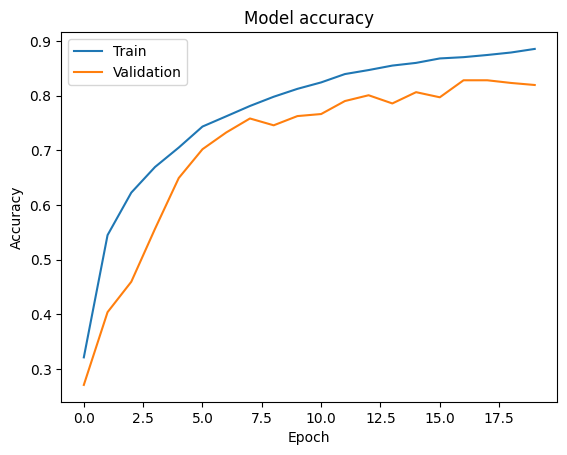

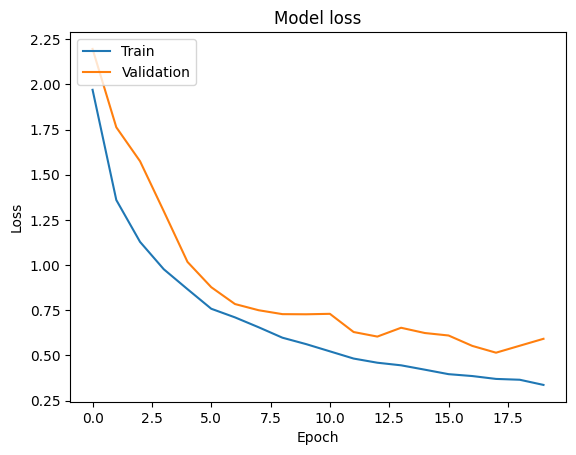

In [ ]:
restune_plot = plot_training_history(history_fine)
restune_plot